# Hard spheres model demo on MNIST data

## Imports

In [1]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data

%cd -

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Load data

In [134]:

phis = [0.74] # Add more phis here
path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  400


class          x          y         r
experiment sample                                           
phi-0.74   sample-245     16 -12.952663 -10.228402  1.432632
           sample-245      8   7.611846  -7.796729  1.057895
           sample-245      2 -17.756045  19.323664  0.776842
           sample-245      8  -6.733623  21.188015  1.057895
           sample-245      1  23.330076 -11.149313  0.730000
...                      ...        ...        ...       ...
           sample-201     13   1.560774  -9.533826  1.292105
           sample-201      1   4.417034 -13.831392  0.730000
           sample-201      1   7.749583  17.967815  0.730000
           sample-201      1 -10.482027  -0.638836  0.730000
           sample-201      1  17.057946  -4.977512  0.730000

[800000 rows x 4 columns]

In [213]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r

## Build dataset

In [214]:

def get_descriptors(data, experiment, descriptors=["phi"]):
    
    descriptors = []

    phi = float(experiment.split("-")[-1])
    # Assume future data will have more dimensions
    phi = [[phi]] * 3
    descriptors.append(phi)

    # Convert to tensor
    descriptors = torch.tensor(descriptors, dtype=torch.float32)

    # For future compatibility, even if using a single descriptor, 
    # we will keep it as a 2D tensor
    if len(descriptors.shape) == 1:
        descriptors = descriptors.unsqueeze(1)
    
    # In the future descriptors may be tensors instead of scalars, include in design
    if len(descriptors.shape) == 2:
        descriptors = descriptors.unsqueeze(2)

    # descriptors = descriptors.flatten(start_dim=1)

    return descriptors


# Create a dataset
class HSDataset(TensorDataset):
    def __init__(self, dataframe, device="cpu", descriptor_list = ["phi"]):
        print("Creating Dataset")
        print("Descriptor List: ", descriptor_list)
        # Split each experiment and sample into a separate sample

        descriptors = []
        samples = []

        for experiment, sample in dataframe.index.unique(): #TODO: Check if this is the right way to do it
            sample = torch.tensor(dataframe.loc[(experiment, sample),: ].copy().values, dtype=torch.float32, device=device)
            sample_descriptors = get_descriptors(sample, experiment, descriptors=descriptor_list)
            
            samples.append(sample.unsqueeze(0)) # We are creating a 3D tensor of 2D samples
            descriptors.append(sample_descriptors)

        self.x = torch.concat(descriptors) # Descriptors are the input.
        self.y = torch.concat(samples) # Sample point cloud is the target


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        pointcloud = self.x[idx]
        descriptors = self.y[idx]
        return pointcloud, descriptors

dataset = HSDataset(dataframe_scaled, descriptor_list=["phi"])

Creating Dataset
Descriptor List:  ['phi']


/var/folders/q9/ztf8_qts26v_zgn8x6qhqd6h0000gn/T/ipykernel_82899/2827754362.py:38: PerformanceWarning: indexing past lexsort depth may impact performance.
  sample = torch.tensor(dataframe.loc[(experiment, sample),: ].copy().values, dtype=torch.float32, device=device)


In [215]:
print(dataset[:][0].shape)
print(dataset[:][1].shape)

torch.Size([400, 3, 1])
torch.Size([400, 2000, 3])


<Axes: >

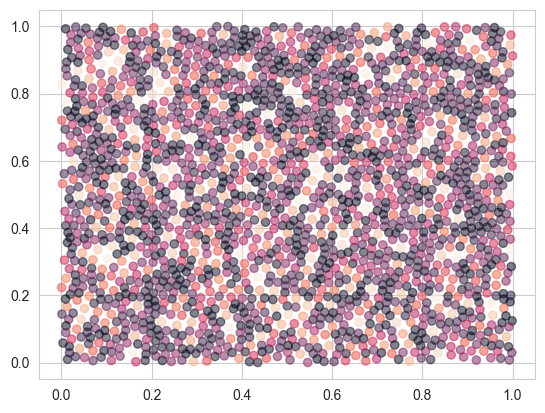

In [216]:
# Create a function that visualizes the point cloud

def plot_pointcloud(pointcloud, ax=None, plot_radius=True):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    xs = pointcloud[:,0]
    ys = pointcloud[:,1]
    rs = pointcloud[:,2]

    if plot_radius:
        ax.scatter(xs, ys, c=rs, s=rs*30, alpha=0.5)
    else:
        ax.scatter(xs, ys, c=rs, alpha=0.5) # TODO: Size of the points is not correct in comparison to the grid size

    return ax

plot_pointcloud(dataset[2][1], plot_radius=False)

## Check on x, y, r distributions

<Axes: xlabel='r', ylabel='Count'>

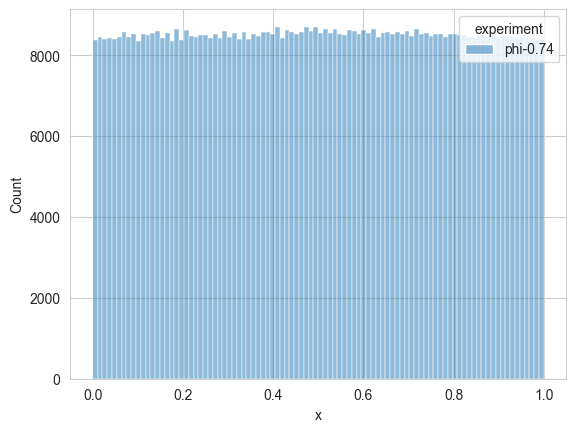

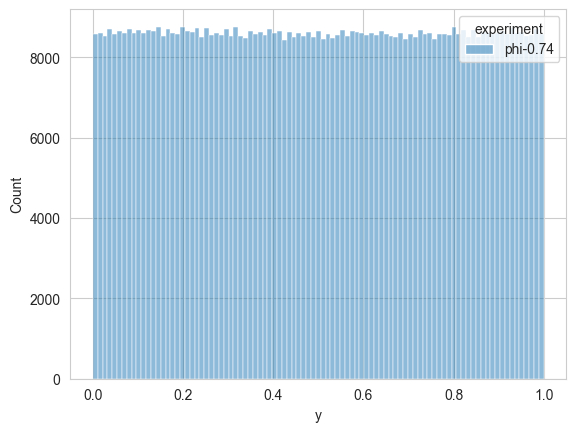

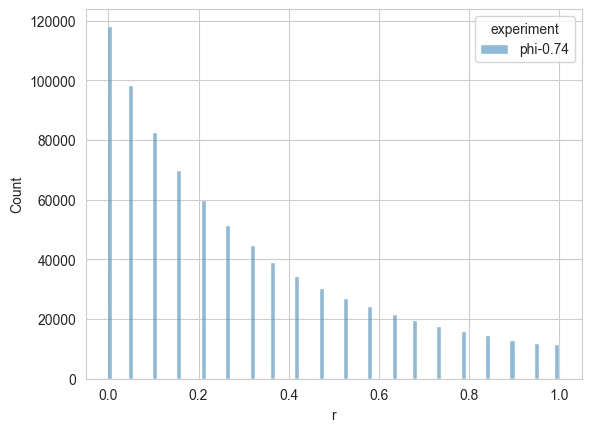

In [221]:
plt.figure()
sns.histplot(dataframe_scaled, x="x", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="y", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="r", hue="experiment", bins="auto")

x, y are uniform distributions

r seems to be an 1/x

# Create model

Create a GAN architecture, which creates point clouds $\hat{X}$ based on the descriptor(s) $\hat{y}$ and a random noise vector $\hat{r}$.

In [218]:
sample_x = dataset[0:5][0]#.transpose(-1,-2)
sample_y = dataset[0:5][1]

print(sample_x.shape, sample_y.shape)

torch.Size([5, 3, 1]) torch.Size([5, 2000, 3])


## Play around with models

(array([49., 19., 12.,  9.,  6.,  1.,  2.,  0.,  1.,  1.]),
 array([0.00375003, 0.15766613, 0.31158223, 0.46549833, 0.61941443,
        0.77333053, 0.92724663, 1.08116274, 1.23507884, 1.38899494,
        1.54291104]),
 <BarContainer object of 10 artists>)

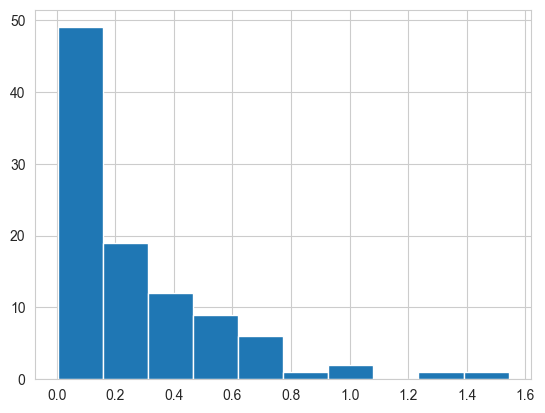

In [219]:
plt.hist(np.random.exponential(0.3, (100,1)))

In [220]:
output_max_samples = 2100
latent_dim = 128
batch_size = sample_x.shape[0]
in_dim = 3 # We have descriptors with three dimensions 
out_dim = 3 # (c), x,y,r


import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, embedding_dim, output_dim, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(embedding_dim, nhead, num_layers, batch_first=True)
        self.linear = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x, x)
        x = self.linear(x)
        return x

# Takes in the input descriptors and returns the output point cloud

desc2latent = nn.Sequential(
            # Input to latent space
            nn.ConvTranspose1d(in_dim, latent_dim, kernel_size=output_max_samples, stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
        )

zx = torch.rand(batch_size, 1, output_max_samples) - 0.5 # X is uniform
zy = torch.rand(batch_size, 1, output_max_samples) - 0.5 # Y is uniform
# R is inverse exponential
zr = torch.tensor(np.random.exponential(0.3, (batch_size, 1, output_max_samples)), dtype=torch.float32)
z = torch.cat([zx, zy, zr], dim=1)

latent2pointcloud = nn.Sequential(
            nn.Conv1d(in_dim, latent_dim, kernel_size=latent_dim, stride=1, padding="same", bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv1d(latent_dim, latent_dim, kernel_size=3, stride=1, padding="same", bias=False),
            nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
        )

print(sample_x.shape)
print(z.shape)

print(desc2latent(sample_x).shape)

print(latent2pointcloud((desc2latent(sample_x))).shape)
print(latent2pointcloud((desc2latent(sample_x)*z)).transpose(-1,-2).shape)

print(summary(latent2pointcloud,depth=1))
print(summary(desc2latent,depth=0))
latent2pointcloud(desc2latent(sample_x)*z).transpose(-1,-2).shape

torch.Size([5, 3, 1])
torch.Size([5, 3, 2100])
torch.Size([5, 3, 2100])
torch.Size([5, 3, 2100])
torch.Size([5, 2100, 3])
Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv1d: 1-1                            49,152
├─LeakyReLU: 1-2                         --
├─Conv1d: 1-3                            49,152
├─Conv1d: 1-4                            384
Total params: 98,688
Trainable params: 98,688
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
Sequential                               806,784
Total params: 806,784
Trainable params: 806,784
Non-trainable params: 0


torch.Size([5, 2100, 3])

In [183]:
dataset[:][1].max()

tensor(2.6378)

In [223]:

class TransformerModel(nn.Module):
    def __init__(self, embedding_dim, output_dim, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(embedding_dim, nhead, num_layers, batch_first=True)
        self.linear = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x, x)
        x = self.linear(x)
        return x

class HSGenerator(nn.Module):
    def __init__(self, output_max_samples, in_dim, latent_dim, out_dim):
        super().__init__()
        # Takes in the input descriptors and returns the output point cloud

        # Maps descriptors to latent space
        self.desc2latent = nn.Sequential(
                    # Input to latent space
                    nn.ConvTranspose1d(in_dim, latent_dim, kernel_size=output_max_samples, stride=1, padding=0, bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
                )

        self.latent2pointcloud = nn.Sequential(
                    nn.Conv1d(in_dim, latent_dim, kernel_size=latent_dim, stride=1, padding="same", bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, latent_dim, kernel_size=3, stride=1, padding="same", bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, latent_dim, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.LeakyReLU(0.2),
                )
        

        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.output_max_samples = output_max_samples


    def forward(self, d: torch.tensor):

        # Input d: Batch x Descriptors x 1 # TODO: In the future a single descriptor will be a 1D tensor, changing dimensions to Batch x Descriptors x NFeatures
        # Output: Batch x Samples x 4 (class, x, y, r) 
        batch_size = d.shape[0]
        zx = torch.rand(batch_size, 1, self.output_max_samples) # X is uniform
        zy = torch.rand(batch_size, 1, self.output_max_samples) # Y is uniform
        # R is inverse exponential
        zr = torch.tensor(1/np.random.exponential(0.3, (batch_size, 1, self.output_max_samples)), dtype=torch.float32)
        z = torch.cat([zx, zy, zr], dim=1)#.transpose(-1,-2)
        out = self.desc2latent(d) * z
        out = self.latent2pointcloud(out).transpose(-1,-2)
        # Clip output
        return torch.clip(out, 0, 1)

print(HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=64, in_dim=3, out_dim=3)(sample_x).shape)

summary(
    HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=64, in_dim=3, out_dim=3), input_data=sample_x
    )


torch.Size([5, 2000, 64])


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [5, 2000, 64]             --
├─Sequential: 1-1                        [5, 3, 2000]              --
│    └─ConvTranspose1d: 2-1              [5, 64, 2000]             384,000
│    └─LeakyReLU: 2-2                    [5, 64, 2000]             --
│    └─Conv1d: 2-3                       [5, 3, 2000]              192
├─Sequential: 1-2                        [5, 64, 2000]             --
│    └─Conv1d: 2-4                       [5, 64, 2000]             12,288
│    └─LeakyReLU: 2-5                    [5, 64, 2000]             --
│    └─Conv1d: 2-6                       [5, 64, 2000]             12,288
│    └─LeakyReLU: 2-7                    [5, 64, 2000]             --
│    └─Conv1d: 2-8                       [5, 64, 2000]             4,096
│    └─LeakyReLU: 2-9                    [5, 64, 2000]             --
Total params: 412,864
Trainable params: 412,864
Non-trainable params

In [233]:
class HSDiscriminator(nn.Module):
    def __init__(self, channels_img=4, features_d=12):
        # Discriminator takes in the point cloud and returns a list of predicted labels (real/fake) 
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=(5,2), stride=(2,1)
            ),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d, kernel_size=(5,2), stride=(2,1)),
            self._block(features_d, features_d * 2, kernel_size=(5,2), stride=(2,1)),
            self._block(features_d * 2, features_d, kernel_size=(5,2), stride=(2,1)),
            nn.Conv2d(features_d, 1, kernel_size=(4,2)),  # 1x1
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(40,32),
            nn.LeakyReLU(0.2),
            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x.unsqueeze(1))

print(sample_x.shape)
print(sample_y.shape)
HSDiscriminator(channels_img=1)(sample_y).shape

summary(HSDiscriminator(channels_img=1, features_d=64), input_data=sample_y, depth=2)

torch.Size([5, 3, 1])
torch.Size([5, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [5, 1]                    --
├─Sequential: 1-1                        [5, 1]                    --
│    └─Conv2d: 2-1                       [5, 64, 998, 2]           704
│    └─LeakyReLU: 2-2                    [5, 64, 998, 2]           --
│    └─Sequential: 2-3                   [5, 64, 498, 3]           41,088
│    └─Sequential: 2-4                   [5, 128, 248, 4]          82,176
│    └─Sequential: 2-5                   [5, 64, 123, 5]           82,048
│    └─Conv2d: 2-6                       [5, 1, 120, 4]            513
│    └─MaxPool2d: 2-7                    [5, 1, 40, 1]             --
│    └─Flatten: 2-8                      [5, 40]                   --
│    └─Linear: 2-9                       [5, 32]                   1,312
│    └─LeakyReLU: 2-10                   [5, 32]                   --
│    └─Linear: 2-11                      [5, 1]                    3

In [234]:
# if detect_bad_gradients:
#             with autograd.detect_anomaly():
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#                 loss.backward()
#         else:
#             outputs = model(inputs)
#             loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#             loss.backward()
#         grad_norm = torch.nn.utils.clip_grad_norm_(
#             model.parameters(), 50
#         )  # Clip gradients

In [235]:
from tqdm import tqdm
from torch import autograd

# Create a GAN class that takes in the generator and discriminator, and the training data
# The GAN class will be responsible for training the generator and discriminator
# The GAN should train the generator to generate images of the digit that is fed as the input

class GAN(nn.Module):
    def __init__(self, generator, discriminator, trainset, testset, device='cpu', batch_size=32, descriptor_loss=False):
        super(GAN, self).__init__()
        self.trainset = trainset
        self.testset = testset
        self.device = device
        self.batch_size = batch_size

        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.criterion = nn.BCELoss()
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.002, weight_decay=0.0001)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.002, weight_decay=0.0001)

        if descriptor_loss:
            self.descriptor_criterion = nn.RMSELoss()
            # TODO: Implement

    def train_n_epochs(self, epochs, batch_size=32):
        print(f'Starting...\nTime: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

        dataloader = DataLoader(self.trainset, batch_size=batch_size, shuffle=True)


        for epoch in range(epochs):
            self._train_epoch(epoch, batch_size=batch_size, dataloader=dataloader)
        


    def _train_epoch(self, epoch, batch_size=32, dataloader=None):

        if dataloader is None:
            dataloader = DataLoader(self.trainset, batch_size=batch_size, shuffle=True)

        self.generator.train()
        self.discriminator.train()

        mean_loss_d = 0
        mean_loss_g = 0

        d_loss = torch.tensor([0])
        
        for descriptors, real_images in tqdm(dataloader):
            real_images = real_images.to(self.device)
            descriptors = descriptors.to(self.device)

            real_labels = torch.ones(real_images.size(0), 1).to(self.device)
            fake_labels = torch.zeros(real_images.size(0), 1).to(self.device)

            # Train the discriminator
            if epoch < 7: # Only train the discriminator for the first 7 epochs
                self.d_optimizer.zero_grad()

                real_outputs = self.discriminator(real_images)
                d_loss_real = self.criterion(real_outputs, real_labels)
                d_loss_real.backward()

                fake_images = self.generator(descriptors)
                fake_outputs = self.discriminator(fake_images)
                d_loss_fake = self.criterion(fake_outputs, fake_labels)
                d_loss_fake.backward()

                d_loss = d_loss_real + d_loss_fake

                d_grad_norm = torch.nn.utils.clip_grad_norm_(
                self.discriminator.parameters(), 10
                )  # Clip gradients
                self.d_optimizer.step() 
                mean_loss_d += d_loss.item()

            # Train the generator
            self.g_optimizer.zero_grad()

            fake_images = self.generator(descriptors)
            fake_outputs = self.discriminator(fake_images)
            g_loss = self.criterion(fake_outputs, real_labels) # We want the generator to generate images that the discriminator thinks are real
            g_loss.backward()

            g_grad_norm = torch.nn.utils.clip_grad_norm_(
            self.generator.parameters(), 10
            )  # Clip gradients

            self.g_optimizer.step()

            
            mean_loss_g += g_loss.item()


        print(f'Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")},Epoch {epoch}, D loss: {d_loss.item()}, G loss: {g_loss.item()}')

        mean_loss_d /= len(self.trainset)
        mean_loss_g /= len(self.trainset)

        return mean_loss_d, mean_loss_g

    def generate(self, input):
        self.generator.eval()
        return self.generator(input.to(self.device)).detach().cpu()


## Train the model

In [236]:
test_frac = 0.5

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

In [237]:
generator = HSGenerator(output_max_samples=dataset.y.shape[1], in_dim=3, out_dim=3, latent_dim=64)
discriminator = HSDiscriminator(channels_img=1, features_d=32)

print(summary(generator, input_data=sample_x, depth=1))
print(summary(discriminator, input_data=sample_y, depth=1))

gan = GAN(generator, discriminator, trainset, testset, device='cpu')


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [5, 2000, 64]             --
├─Sequential: 1-1                        [5, 3, 2000]              384,192
├─Sequential: 1-2                        [5, 64, 2000]             28,672
Total params: 412,864
Trainable params: 412,864
Non-trainable params: 0
Total mult-adds (G): 4.13
Input size (MB): 0.00
Forward/backward pass size (MB): 20.72
Params size (MB): 1.65
Estimated Total Size (MB): 22.38
Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [5, 1]                    --
├─Sequential: 1-1                        [5, 1]                    53,410
Total params: 53,410
Trainable params: 53,410
Non-trainable params: 0
Total mult-adds (M): 245.19
Input size (MB): 9.60
Forward/backward pass size (MB): 13.05
Params size (MB): 0.21
Estimated Total Size (MB): 22.87


In [240]:
gan.train_n_epochs(50,64)

Starting...
Time: 2024-05-19 13:06:55


  0%|          | 0/5 [00:04<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x840 and 40x32)

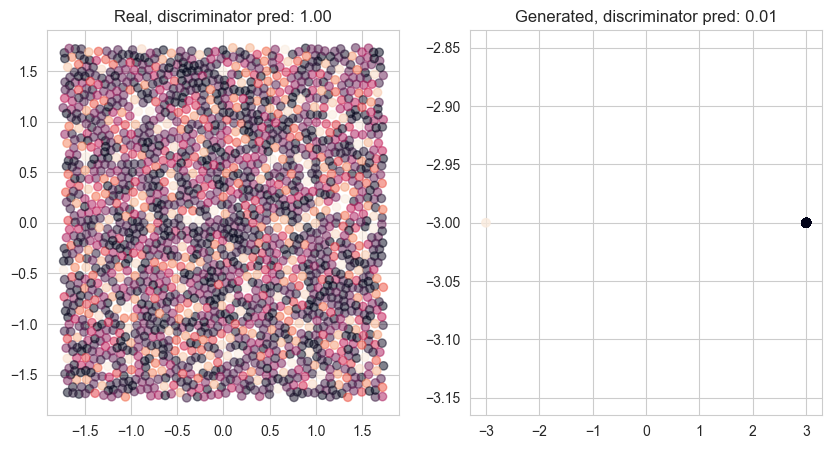

In [211]:
# Check on the created figures
def plot_sample_figures(generator, discriminator, dataset, n=5, plot_radius=True):
    sample_generated_y = generator(dataset[:][0][0:n])
    sample_y = dataset[:][1][0:n]

    # Illustrate the point cloud

    fig, ax = plt.subplots(1,2, figsize=(10,5))

    plot_pointcloud(sample_y[0], ax=ax[0], plot_radius=plot_radius)

    plot_pointcloud(sample_generated_y[0].detach().numpy(), ax=ax[1], plot_radius=plot_radius)

    # Discriminator predictions on the generated data and the real data

    real_preds = discriminator(sample_y)
    preds = discriminator(sample_generated_y)


    ax[0].set_title("Real, discriminator pred: {:.2f}".format(real_preds[0].item()))
    ax[1].set_title("Generated, discriminator pred: {:.2f}".format(preds[0].item()))

    plt.show()

    # Plot distribution of the generated data
    # sns.histplot(sample_generated_y[0].detach().numpy()[:,0], bins="auto")
    # plt.title("X")
    # plt.show()

    # sns.histplot(sample_generated_y[0].detach().numpy()[:,1], bins="auto")
    # plt.title("Y")
    # plt.show()

    # sns.histplot(sample_generated_y[0].detach().numpy()[:,2], bins="auto")
    # plt.title("R")
    # plt.show()

plot_sample_figures(generator, discriminator, dataset, n=3, plot_radius=False)

In [ ]:
# Check physical feasibility of the generated point clouds

# Start with summing overlapping areas

def count_overlaps(xs, ys, rs):
    # Count the number of overlaps in the pointcloud
    # Overlapping areas are areas where the radius of a point is larger than the distance to the nearest point minus the radius of the nearest point

    # n_points = pointclouds.shape[0]
    # overlaps = 0

    # distances = torch.cdist(pointclouds, pointclouds)
    pass
    

   


# Check if the sum of overlapping areas is correct
# pointclouds = dataset[:][1]
# count_overlaps(pointclouds)


# Profile model performance for computational bottlenecks

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        generator(sample_x)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference        41.71%       5.928ms       100.00%      14.214ms      14.214ms             1  
               aten::convolution         0.27%      38.000us        30.12%       4.281ms       2.140ms             2  
              aten::_convolution        18.66%       2.652ms        29.85%       4.243ms       2.122ms             2  
          aten::conv_transpose1d         0.04%       5.000us        20.88%       2.968ms       2.968ms             1  
                     aten::randn         5.29%     752.000us        17.73%       2.520ms       2.520ms             1  
                   aten::normal_        12.40%  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        discriminator(sample_y)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        26.75%       4.685ms       100.00%      17.513ms      17.513ms             1  
                     aten::conv2d         0.22%      39.000us        58.93%      10.321ms       2.064ms             5  
                aten::convolution         0.50%      88.000us        58.71%      10.282ms       2.056ms             5  
               aten::_convolution         0.36%      63.000us        58.21%      10.194ms       2.039ms             5  
         aten::mkldnn_convolution        57.36%      10.045ms        57.85%      10.131ms       2.026ms             5  
                 aten::leaky_relu       

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [ ]:
metadata.drop_duplicates()

N          L            A
experiment sample                                  
phi-0.74   sample-245  2000  46.887094  1626.815709
           sample-46   2000  46.887094  1626.815709
           sample-24   2000  46.887094  1626.815709
           sample-348  2000  46.887094  1626.815709
phi-0.72   sample-245  2000  47.533843  1626.815709
           sample-77   2000  47.533843  1626.815709
           sample-83   2000  47.533843  1626.815709
           sample-286  2000  47.533843  1626.815709